In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from statistics import mode
import re
from xgboost import XGBClassifier

In [7]:
df = pd.read_csv('h1b_kaggle.csv')

In [8]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002458 entries, 0 to 3002457
Data columns (total 11 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   CASE_STATUS         object 
 2   EMPLOYER_NAME       object 
 3   SOC_NAME            object 
 4   JOB_TITLE           object 
 5   FULL_TIME_POSITION  object 
 6   PREVAILING_WAGE     float64
 7   YEAR                float64
 8   WORKSITE            object 
 9   lon                 float64
 10  lat                 float64
dtypes: float64(4), int64(1), object(6)
memory usage: 252.0+ MB


,Unnamed: 0,PREVAILING_WAGE,YEAR,lon,lat
count,3.002458e+06,3.002373e+06,3.002445e+06,2.895216e+06,2.895216e+06
mean,1.501230e+06,1.469984e+05,2.013855e+03,-9.213441e+01,3.816054e+01
std,8.667351e+05,5.287609e+06,1.680612e+00,1.965591e+01,4.672835e+00
min,1.000000e+00,0.000000e+00,2.011000e+03,-1.578583e+02,1.343719e+01
25%,7.506152e+05,5.437100e+04,2.012000e+03,-1.119261e+02,3.416536e+01
50%,1.501230e+06,6.502100e+04,2.014000e+03,-8.615862e+01,3.910312e+01
75%,2.251844e+06,8.143200e+04,2.015000e+03,-7.551381e+01,4.088374e+01
max,3.002458e+06,6.997607e+09,2.016000e+03,1.457298e+02,6.483778e+01


In [57]:
df['CASE_STATUS'].unique()
df.head(60)

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,NEW_EMPLOYER,OCCUPATION,state
0,1,0,university of michigan,biochemists and biophysicists,POSTDOCTORAL RESEARCH FELLOW,N,36067.00,2016.0,"ANN ARBOR, MICHIGAN",university,Advance Sciences,MICHIGAN
1,2,0,"goodman networks, inc.",chief executives,CHIEF OPERATING OFFICER,Y,138611.00,2016.0,"PLANO, TEXAS",non university,Management Occupation,TEXAS
2,3,0,"ports america group, inc.",chief executives,CHIEF PROCESS OFFICER,Y,138611.00,2016.0,"JERSEY CITY, NEW JERSEY",non university,Management Occupation,JERSEY
3,4,0,"gates corporation, a wholly-owned subsidiary o...",chief executives,"REGIONAL PRESIDEN, AMERICAS",Y,138611.00,2016.0,"DENVER, COLORADO",non university,Management Occupation,COLORADO
5,6,0,burger king corporation,chief executives,"EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...",Y,138611.00,2016.0,"MIAMI, FLORIDA",non university,Management Occupation,FLORIDA
6,7,0,bt and mk energy and commodities,chief executives,CHIEF OPERATING OFFICER,Y,91021.00,2016.0,"HOUSTON, TEXAS",non university,Management Occupation,TEXAS
7,8,0,"globo mobile technologies, inc.",chief executives,CHIEF OPERATIONS OFFICER,Y,138611.00,2016.0,"SAN JOSE, CALIFORNIA",non university,Management Occupation,CALIFORNIA
8,9,0,esi companies inc.,chief executives,PRESIDENT,Y,127546.00,2016.0,"MEMPHIS, TEXAS",non university,Management Occupation,TEXAS
10,11,0,h.j. heinz company,chief executives,"CHIEF INFORMATION OFFICER, HEINZ NORTH AMERICA",Y,138611.00,2016.0,"PITTSBURGH, PENNSYLVANIA",non university,Management Occupation,PENNSYLVANIA
11,12,0,dow corning corporation,chief executives,VICE PRESIDENT AND CHIEF HUMAN RESOURCES OFFICER,Y,138611.00,2016.0,"MIDLAND, MICHIGAN",non university,Management Occupation,MICHIGAN


In [10]:
import warnings
warnings.filterwarnings("ignore")
df.CASE_STATUS[df['CASE_STATUS']=='REJECTED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='INVALIDATED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'] = 'DENIED'
df.CASE_STATUS[df['CASE_STATUS']=='CERTIFIED-WITHDRAWN'] = 'CERTIFIED'

In [11]:
##Drop rows with withdrawn
df.EMPLOYER_NAME.describe()
df = df.drop(df[df.CASE_STATUS == 'WITHDRAWN'].index)

## Storing non null in df w.r.t. case status
df = df[df['CASE_STATUS'].notnull()]
print(df['CASE_STATUS'].value_counts())

CERTIFIED    2818282
DENIED         94364
Name: CASE_STATUS, dtype: int64


In [12]:
##check count of NAN
count_nan = len(df) - df.count()
print(count_nan)

Unnamed: 0                 0
CASE_STATUS                0
EMPLOYER_NAME             18
SOC_NAME               17073
JOB_TITLE                 10
FULL_TIME_POSITION         1
PREVAILING_WAGE           53
YEAR                       0
WORKSITE                   0
lon                   102844
lat                   102844
dtype: int64


In [13]:
## Filling na in employer name with mode
df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].fillna(df['EMPLOYER_NAME'].mode()[0])

In [14]:
##to check the percentile in wages
print(np.nanpercentile(df.PREVAILING_WAGE,98))
df.PREVAILING_WAGE.median()

138611.0


65000.0

In [15]:
## replacing min and max with 2 and 98 percentile
df.loc[df.PREVAILING_WAGE < 34029, 'PREVAILING_WAGE']= 34029
df.loc[df['PREVAILING_WAGE'] > 138703, 'PREVAILING_WAGE']= 138703
df.PREVAILING_WAGE.fillna(df.PREVAILING_WAGE.mean(), inplace = True)

In [16]:
## Filling na in JOB_TITLE and FULL_TIME_POSITION with mode
df['JOB_TITLE'] = df['JOB_TITLE'].fillna(df['JOB_TITLE'].mode()[0])
df['FULL_TIME_POSITION'] = df['FULL_TIME_POSITION'].fillna(df['FULL_TIME_POSITION'].mode()[0])
df['SOC_NAME'] = df['SOC_NAME'].fillna(df['SOC_NAME'].mode()[0])

In [17]:
foo1 = df['FULL_TIME_POSITION']=='Y'
foo2 = df['CASE_STATUS']=='CERIFIED'
print(len(df[foo1])/len(df))

fooy = df.FULL_TIME_POSITION[df['FULL_TIME_POSITION']=='Y'].count()
foox = df.CASE_STATUS[df['CASE_STATUS']=='CERIFIED'].count()
print(fooy/df.FULL_TIME_POSITION.count())

0.8587040786968275
0.8587040786968275


In [18]:
# Dropping lat and lon columns
df = df.drop('lat', axis = 1)
df = df.drop('lon', axis = 1)

In [19]:
df['NEW_EMPLOYER'] = np.nan
df.shape

(2912646, 10)

In [20]:
warnings.filterwarnings("ignore")

df['EMPLOYER_NAME'] = df['EMPLOYER_NAME'].str.lower()
df.NEW_EMPLOYER[df['EMPLOYER_NAME'].str.contains('university')] = 'university'
df['NEW_EMPLOYER']= df.NEW_EMPLOYER.replace(np.nan, 'non university', regex=True)

In [21]:
# Creating occupation and mapping the values
warnings.filterwarnings("ignore")

df['OCCUPATION'] = np.nan
df['SOC_NAME'] = df['SOC_NAME'].str.lower()
df.OCCUPATION[df['SOC_NAME'].str.contains('computer','programmer')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('software','web developer')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('database')] = 'computer occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('math','statistic')] = 'Mathematical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('predictive model','stats')] = 'Mathematical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('teacher','linguist')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('professor','Teach')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('school principal')] = 'Education Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('medical','doctor')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('physician','dentist')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('Health','Physical Therapists')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('surgeon','nurse')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('psychiatr')] = 'Medical Occupations'
df.OCCUPATION[df['SOC_NAME'].str.contains('chemist','physicist')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biology','scientist')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('biologi','clinical research')] = 'Advance Sciences'
df.OCCUPATION[df['SOC_NAME'].str.contains('public relation','manage')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('management','operation')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('chief','plan')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('executive')] = 'Management Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('advertis','marketing')] = 'Marketing Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('promotion','market research')] = 'Marketing Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('business','business analyst')] = 'Business Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('business systems analyst')] = 'Business Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('accountant','finance')] = 'Financial Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('financial')] = 'Financial Occupation'
df.OCCUPATION[df['SOC_NAME'].str.contains('engineer','architect')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('surveyor','carto')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('technician','drafter')] = 'Architecture & Engineering'
df.OCCUPATION[df['SOC_NAME'].str.contains('information security','information tech')] = 'Architecture & Engineering'
df['OCCUPATION']= df.OCCUPATION.replace(np.nan, 'Others', regex=True)

In [22]:
## Splitting city and state and capturing state in another variable
df['state'] = df.WORKSITE.str.split('\s+').str[-1]

In [23]:
print(df.head())

   Unnamed: 0 CASE_STATUS                                      EMPLOYER_NAME  \
0           1   CERTIFIED                             university of michigan   
1           2   CERTIFIED                             goodman networks, inc.   
2           3   CERTIFIED                          ports america group, inc.   
3           4   CERTIFIED  gates corporation, a wholly-owned subsidiary o...   
5           6   CERTIFIED                            burger king corporation   

                        SOC_NAME  \
0  biochemists and biophysicists   
1               chief executives   
2               chief executives   
3               chief executives   
5               chief executives   

                                           JOB_TITLE FULL_TIME_POSITION  \
0                       POSTDOCTORAL RESEARCH FELLOW                  N   
1                            CHIEF OPERATING OFFICER                  Y   
2                              CHIEF PROCESS OFFICER                  Y   
3 

In [24]:
from sklearn import preprocessing
class_mapping = {'CERTIFIED':0, 'DENIED':1}
df["CASE_STATUS"] = df["CASE_STATUS"].map(class_mapping)

In [25]:
print(df.head())

   Unnamed: 0  CASE_STATUS                                      EMPLOYER_NAME  \
0           1            0                             university of michigan   
1           2            0                             goodman networks, inc.   
2           3            0                          ports america group, inc.   
3           4            0  gates corporation, a wholly-owned subsidiary o...   
5           6            0                            burger king corporation   

                        SOC_NAME  \
0  biochemists and biophysicists   
1               chief executives   
2               chief executives   
3               chief executives   
5               chief executives   

                                           JOB_TITLE FULL_TIME_POSITION  \
0                       POSTDOCTORAL RESEARCH FELLOW                  N   
1                            CHIEF OPERATING OFFICER                  Y   
2                              CHIEF PROCESS OFFICER                  Y

In [26]:
test1 = pd.Series(df['JOB_TITLE'].ravel()).unique()
print(pd.DataFrame(test1))

                                                        0
0                            POSTDOCTORAL RESEARCH FELLOW
1                                 CHIEF OPERATING OFFICER
2                                   CHIEF PROCESS OFFICER
3                             REGIONAL PRESIDEN, AMERICAS
4       EXECUTIVE V P, GLOBAL DEVELOPMENT AND PRESIDEN...
...                                                   ...
284544                              DFT MODELING ENGINEER
284545      SENIOR SOFTWARE ENGINEER (LTE PROTOCOL STACK)
284546                       CHEMISTRY  - SCIENCE TEACHER
284547                         SALES AND LOGISTIC MANAGER
284548                            APPRAISERS, REAL ESTATE

[284549 rows x 1 columns]


In [30]:
df1 = df.copy()

In [31]:
df1[['CASE_STATUS', 'FULL_TIME_POSITION', 'YEAR','NEW_EMPLOYER','OCCUPATION','state']] = df1[['CASE_STATUS', 'FULL_TIME_POSITION', 'YEAR','NEW_EMPLOYER','OCCUPATION','state']].apply(lambda x: x.astype('category'))

In [32]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2912646 entries, 0 to 3002392
Data columns (total 8 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Unnamed: 0          int64   
 1   CASE_STATUS         category
 2   FULL_TIME_POSITION  category
 3   PREVAILING_WAGE     float64 
 4   YEAR                category
 5   NEW_EMPLOYER        category
 6   OCCUPATION          category
 7   state               category
dtypes: category(6), float64(1), int64(1)
memory usage: 83.3 MB


In [33]:
X = df.drop('CASE_STATUS', axis=1)
y = df.CASE_STATUS

seed = 7
test_size = 0.40
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
X_train.columns

Index(['Unnamed: 0', 'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'YEAR',
       'NEW_EMPLOYER', 'OCCUPATION', 'state'],
      dtype='object')

In [34]:
print(X_train.isnull().sum())

Unnamed: 0            0
FULL_TIME_POSITION    0
PREVAILING_WAGE       0
YEAR                  0
NEW_EMPLOYER          0
OCCUPATION            0
state                 0
dtype: int64


In [35]:
X_train_encode = pd.get_dummies(X_train)
X_test_encode = pd.get_dummies(X_test)

In [36]:
y_train.head()

1005328    0
816196     0
1582854    0
825095     0
2963078    0
Name: CASE_STATUS, dtype: int64

In [38]:
train_X = X_train_encode.values
train_y = y_train.values

In [39]:
import xgboost
gbm=xgboost.XGBClassifier(max_features='sqrt', subsample=0.8, random_state=10)

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
parameters = [{'n_estimators': [10, 100]},
              {'learning_rate': [0.1, 0.01, 0.5]}]

In [42]:
grid_search = GridSearchCV(estimator = gbm, param_grid = parameters, scoring='accuracy', cv = 3, n_jobs=-1)

In [43]:
grid_search = grid_search.fit(train_X, train_y)

[13:18:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:18:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [45]:
warnings.filterwarnings("ignore")

grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_

({'learning_rate': 0.5}, 0.9691734946529128)

In [46]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.5, max_delta_step=0,
              max_depth=6, max_features='sqrt', min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=10,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [55]:
gbm=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.5, max_delta_step=0,
       max_depth=3, max_features='sqrt', min_child_weight=1, missing=1,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=10, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8).fit(train_X, train_y)

[13:48:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "max_features", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:48:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [56]:
y_pred = gbm.predict(X_test_encode.values)

In [57]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[1126480     672]
 [  36394    1513]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98   1127152
           1       0.69      0.04      0.08     37907

    accuracy                           0.97   1165059
   macro avg       0.83      0.52      0.53   1165059
weighted avg       0.96      0.97      0.95   1165059



In [58]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.5196586397815649

0.5196586397815649


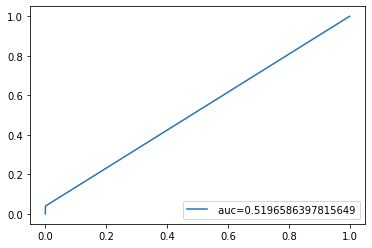

In [59]:
from sklearn import metrics
import matplotlib.pyplot as plt

fpr_xg, tpr_xg, thresholds = metrics.roc_curve(y_test, y_pred)
print(metrics.auc(fpr_xg, tpr_xg))
auc_xgb = np.trapz(tpr_xg,fpr_xg)
plt.plot(fpr_xg,tpr_xg,label=" auc="+str(auc_xgb))
plt.legend(loc=4)
plt.show()

In [60]:
import pickle

"""Saving the Model"""
XGB_Model_h1b = 'XGB_Model_h1b.sav'
pickle.dump(gbm, open(XGB_Model_h1b, 'wb'))